In [9]:
import numpy as np
import pandas as pd

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import sklearn.preprocessing as pre
from transforming import WithSelected, Apply, Calc, Select, TypeRecast, boruta

from sklearn.metrics import f1_score, roc_auc_score

__loading__

In [2]:
source = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

X_source = source.drop(columns=['id', 'target'])
y = source.target

__preprocessing & FE__

In [3]:
original = ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']
pipe = make_pipeline(
    # is_norma features
    # Calc('1*((1.008 < gravity) & (gravity < 1.030))', to='gravity_is_norma'),
    # Calc('1*(urea <= 35)', to='urea_is_norma'),
    # Calc('1*((2.5 < calc) & (calc < 7.5))', to='calc_is_norma'),

    # pH-like
    Calc('-np.log10(calc * 10e-6)', to='pCalc'),
    Calc('-np.log10(urea * 10e-6)', to='pUr'),
    Calc('-np.log10(osmo)', to='pOs'),
    Calc('-np.log10(cond)', to='pCond'),
    # Calc('pCalc - ph', to='pCalc_ph_diff'),
    # Calc('pUr - ph', to='pUr_ph_diff'),

    # prod & ratio
    Calc('gravity / ph', to='gravity_ph_rate'),
    Calc('gravity * ph', to='gravity_ph_prod'),
    Calc('gravity * osmo', to='gravity_osmo_prod'),
    Calc('gravity / calc', to='gravity_calc_rate'),
    Calc('osmo / cond', to='osmo_cond_rate'),
    Calc('osmo * urea', to='osmo_urea_prod'),
    Calc('osmo * ph', to='osmo_ph_prod'),
    Calc('(cond * urea) / ph', to='cond_urea_prod_ph_rate'),
    Calc('cond * calc', to='cond_calc_prod'),
    Calc('(gravity * osmo) / urea', to='gravity_osmo_prod_urea_rate'),

    # Calc('calc / urea', to='calc_urea_rate'),
    # Calc('calc / ph', to='calc_ph_rate'),
    Calc('pOs / gravity', to='pOs_gravity_rate'),
    Calc('pOs / ph', to='pOs_ph_rate'),
    Calc('gravity / ph', to='gravity_ph_rate'),
    Calc('gravity / pCalc', to='gravity_pCalc_rate'),
    Calc('pCond / ph', to='pCond_ph_rate'),
    Calc('pCond / pCalc', to='pCond_pCalc_rate'),
    Calc('pCond / pUr', to='pCond_pUr_rate'),

    # Calc('(osmo * gravity) / (cond * ph)', to='osmo_gravity_prod_cond_ph_prod_rate'),
    # Calc('cond / (urea * calc)', to='cond_(urea_calc_prod)_rate'),

    # Calc('', to=''),
    # Calc('', to=''),

    # power
    WithSelected(None, 'pow')(
    # WithSelected(original, 'pow')(
        pre.PowerTransformer()
    ),
    # categirues/binaries
    WithSelected(original, suffix='bins')(
    # WithSelected(lambda columns: [col for col in columns if 'norma' not in col and 'pow' not in col], suffix='bins')(
        pre.KBinsDiscretizer(7, encode='onehot', strategy='kmeans')
    ),
    # analysis
    Apply(
        # estimator=LinearDiscriminantAnalysis(),
        # locpipe=pre.Normalizer(),
        estimator=LinearDiscriminantAnalysis(solver='lsqr'),
        locpipe=pre.StandardScaler(),
        # on=lambda columns: [col for col in columns if 'pow' in col],
        to='lda',
        as_proba=True
    ),
    # Apply(
    #     estimator=QuadraticDiscriminantAnalysis(),
    #     locpipe=pre.StandardScaler(),
    #     # on=lambda columns: [col for col in columns if 'pow' in col],
    #     to='lda',
    #     as_proba=True
    # ),
    Apply(
        estimator=KNeighborsClassifier(7, leaf_size=30, n_jobs=-1),
        to='neighbours',
        as_proba=True
    ),
    # Apply(
    #     estimator=IsolationForest(n_estimators=10, max_samples='auto', warm_start=True, bootstrap=True, n_jobs=-1, random_state=17),
    #     locpipe=pre.Normalizer(),
    #     to='isolation'
    # ),
    # calculations with generated features
    Calc('neighbours / calc', to='ngb_calc_rate'),
    Calc('lda / calc', to='lda_calc_rate'),
    Calc('neighbours / ph', to='ngb_ph_rate'),
    Calc('lda / ph', to='lda_ph_rate'),
    Calc('neighbours / gravity', to='ngb_gravity_rate'),
    Calc('lda / gravity', to='lda_gravity_rate'),
    # Calc('neighbours / lda', to='ngb_lda_rate'),
    Calc('(osmo / gravity) * lda', to='osmo_gravity_rate_lda_weighted'),

    Calc('(calc * urea / ph) * lda', to='ion_lda_prod'),
    Calc('(calc * urea / ph) * neighbours', to='ion_ngb_prod'),

    TypeRecast(
        int=lambda columns: [col for col in columns if 'bins' in col],
    )
    
    # Select(original, mode='drop'),
)


In [4]:
# X = source.drop(columns=['id', 'target'])     # basic dataframe
# X = pipe.fit_transform(X_source, y).astype(types)
X = pipe.fit_transform(X_source, y)
X.head()

,gravity,ph,osmo,cond,urea,calc,pCalc,pUr,pOs,pCond,...,neighbours,ngb_calc_rate,lda_calc_rate,ngb_ph_rate,lda_ph_rate,ngb_gravity_rate,lda_gravity_rate,osmo_gravity_rate_lda_weighted,ion_lda_prod,ion_ngb_prod
0,1.013,6.19,443,14.8,124,1.45,4.838632,2.906578,-2.646404,-1.170262,...,0.285714,0.197044,0.216111,0.046157,0.050624,0.282048,0.309340,137.037565,9.102158,8.299100
1,1.025,5.40,703,23.6,394,4.18,4.378824,2.404504,-2.846955,-1.372912,...,0.285714,0.068353,0.181457,0.052910,0.140461,0.278746,0.739989,520.212501,231.327928,87.138624
2,1.009,6.13,371,24.5,159,9.04,4.043832,2.798603,-2.569374,-1.389166,...,0.285714,0.031606,0.079498,0.046609,0.117236,0.283166,0.712248,264.244000,168.510696,66.994174
3,1.021,4.91,442,20.8,398,6.63,4.178486,2.400117,-2.645422,-1.318063,...,0.714286,0.107735,0.150286,0.145476,0.202932,0.699594,0.975903,431.349267,535.485413,383.872563
4,1.021,5.53,874,17.8,385,2.21,4.655608,2.414539,-2.941511,-1.250420,...,0.714286,0.323206,0.199645,0.129166,0.079786,0.699594,0.432140,377.690433,67.885679,109.900542


__fit & validate__

In [5]:
def checkup(estimator, X, folds=7):
    metrics = []
    kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=19)
    for f, (train, valid) in enumerate(kf.split(X, y)):
        estimator.fit(X.loc[train], y[train])
        
        pt = estimator.predict_proba(X.loc[train]).T[1]
        pv = estimator.predict_proba(X.loc[valid]).T[1]

        auc_train = roc_auc_score(y[train], pt)
        auc_valid = roc_auc_score(y[valid], pv)
        f1_train = f1_score(y[train], pt > 0.5)
        f1_valid = f1_score(y[valid], pv > 0.5)
        metrics.append((auc_train, f1_train, auc_valid, f1_valid))
        print(f'Fold: {f}; TRAIN ROC AUC={auc_train:.5f}; TRAIN f1={f1_train:.5f} | VALID ROC AUC={auc_valid:.5f}; VALID f1={f1_valid:.5f}')
    means = np.mean(metrics, axis=0)
    print(f'MEAN: TRAIN ROC AUC={means[0]:.5f}; TRAIN f1={means[1]:.5f} | VALID ROC AUC={means[2]:.5f}; VALID f1={means[3]:.5f}')
    return estimator

In [8]:
est = checkup(LinearDiscriminantAnalysis('lsqr'), X, folds=7)

Fold: 0; TRAIN ROC AUC=0.50000; TRAIN f1=0.61448 | VALID ROC AUC=0.50000; VALID f1=0.62069
Fold: 1; TRAIN ROC AUC=0.93346; TRAIN f1=0.00000 | VALID ROC AUC=0.84149; VALID f1=0.00000
Fold: 2; TRAIN ROC AUC=0.50000; TRAIN f1=0.61598 | VALID ROC AUC=0.50000; VALID f1=0.61176
Fold: 3; TRAIN ROC AUC=0.93067; TRAIN f1=0.65833 | VALID ROC AUC=0.79487; VALID f1=0.62162
Fold: 4; TRAIN ROC AUC=0.92961; TRAIN f1=0.83436 | VALID ROC AUC=0.82867; VALID f1=0.75472
Fold: 5; TRAIN ROC AUC=0.91955; TRAIN f1=0.00000 | VALID ROC AUC=0.90793; VALID f1=0.00000
Fold: 6; TRAIN ROC AUC=0.92299; TRAIN f1=0.00000 | VALID ROC AUC=0.88194; VALID f1=0.00000
MEAN: TRAIN ROC AUC=0.80518; TRAIN f1=0.38902 | VALID ROC AUC=0.75070; VALID f1=0.37268


In [6]:
checkup(KNeighborsClassifier(11, leaf_size=17, n_jobs=-1), X, folds=7);

Fold: 0; TRAIN ROC AUC=0.72974; TRAIN f1=0.62876 | VALID ROC AUC=0.72952; VALID f1=0.67857
Fold: 1; TRAIN ROC AUC=0.74023; TRAIN f1=0.64596 | VALID ROC AUC=0.62821; VALID f1=0.52000
Fold: 2; TRAIN ROC AUC=0.74931; TRAIN f1=0.64026 | VALID ROC AUC=0.66142; VALID f1=0.58182
Fold: 3; TRAIN ROC AUC=0.74422; TRAIN f1=0.62783 | VALID ROC AUC=0.60664; VALID f1=0.48000
Fold: 4; TRAIN ROC AUC=0.73108; TRAIN f1=0.63091 | VALID ROC AUC=0.59674; VALID f1=0.50847
Fold: 5; TRAIN ROC AUC=0.75133; TRAIN f1=0.63087 | VALID ROC AUC=0.63403; VALID f1=0.56604
Fold: 6; TRAIN ROC AUC=0.74115; TRAIN f1=0.61486 | VALID ROC AUC=0.66030; VALID f1=0.44898
MEAN: TRAIN ROC AUC=0.74101; TRAIN f1=0.63135 | VALID ROC AUC=0.64527; VALID f1=0.54055


In [10]:
est = checkup(GaussianProcessClassifier(random_state=19), X, folds=7);

Fold: 0; TRAIN ROC AUC=1.00000; TRAIN f1=1.00000 | VALID ROC AUC=0.51852; VALID f1=0.07143
Fold: 1; TRAIN ROC AUC=1.00000; TRAIN f1=1.00000 | VALID ROC AUC=0.50000; VALID f1=0.00000
Fold: 2; TRAIN ROC AUC=1.00000; TRAIN f1=1.00000 | VALID ROC AUC=0.50000; VALID f1=0.00000
Fold: 3; TRAIN ROC AUC=1.00000; TRAIN f1=1.00000 | VALID ROC AUC=0.50000; VALID f1=0.00000
Fold: 4; TRAIN ROC AUC=1.00000; TRAIN f1=1.00000 | VALID ROC AUC=0.50000; VALID f1=0.00000
Fold: 5; TRAIN ROC AUC=1.00000; TRAIN f1=1.00000 | VALID ROC AUC=0.51923; VALID f1=0.07407
Fold: 6; TRAIN ROC AUC=1.00000; TRAIN f1=1.00000 | VALID ROC AUC=0.50000; VALID f1=0.00000
MEAN: TRAIN ROC AUC=1.00000; TRAIN f1=1.00000 | VALID ROC AUC=0.50539; VALID f1=0.02079


### LGBM

Fold: 0; TRAIN ROC AUC=0.96309; TRAIN f1=0.86769 | VALID ROC AUC=0.85297; VALID f1=0.74576
Fold: 1; TRAIN ROC AUC=0.95881; TRAIN f1=0.85890 | VALID ROC AUC=0.88462; VALID f1=0.82143
Fold: 2; TRAIN ROC AUC=0.96169; TRAIN f1=0.88822 | VALID ROC AUC=0.85256; VALID f1=0.76000
Fold: 3; TRAIN ROC AUC=0.95926; TRAIN f1=0.86850 | VALID ROC AUC=0.91725; VALID f1=0.81481
Fold: 4; TRAIN ROC AUC=0.96015; TRAIN f1=0.85970 | VALID ROC AUC=0.87762; VALID f1=0.78571
Fold: 5; TRAIN ROC AUC=0.95811; TRAIN f1=0.85882 | VALID ROC AUC=0.94172; VALID f1=0.85714
Fold: 6; TRAIN ROC AUC=0.95448; TRAIN f1=0.85886 | VALID ROC AUC=0.92245; VALID f1=0.82759
MEAN: TRAIN ROC AUC=0.95937; TRAIN f1=0.86581 | VALID ROC AUC=0.89274; VALID f1=0.80178


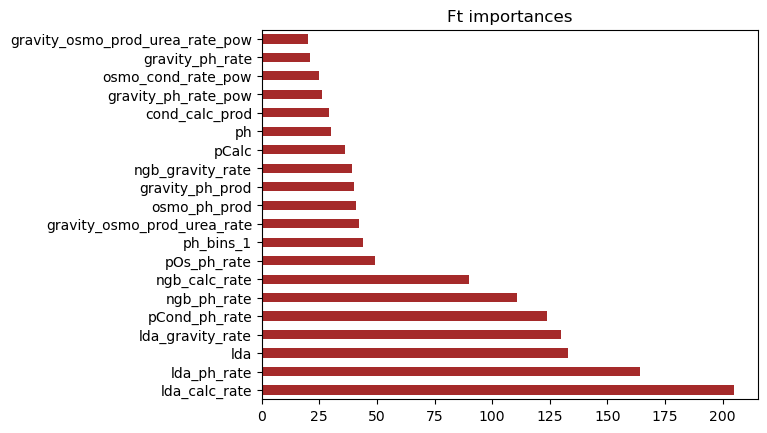

In [7]:
# FIT LGBM
est = checkup(LGBMClassifier(n_estimators=250, learning_rate=0.01, max_depth=3, n_jobs=-1, random_state=11), X, folds=7);
feat_importances = pd.Series(est.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh', title='Ft importances', color='brown');

### CatBoost

Fold: 0; TRAIN ROC AUC=0.95053; TRAIN f1=0.83692 | VALID ROC AUC=0.86195; VALID f1=0.72727
Fold: 1; TRAIN ROC AUC=0.94423; TRAIN f1=0.83333 | VALID ROC AUC=0.88228; VALID f1=0.83636
Fold: 2; TRAIN ROC AUC=0.94683; TRAIN f1=0.84242 | VALID ROC AUC=0.87529; VALID f1=0.76000
Fold: 3; TRAIN ROC AUC=0.94278; TRAIN f1=0.84756 | VALID ROC AUC=0.89627; VALID f1=0.83636
Fold: 4; TRAIN ROC AUC=0.94217; TRAIN f1=0.83988 | VALID ROC AUC=0.88345; VALID f1=0.80000
Fold: 5; TRAIN ROC AUC=0.93558; TRAIN f1=0.82635 | VALID ROC AUC=0.94988; VALID f1=0.89286
Fold: 6; TRAIN ROC AUC=0.93769; TRAIN f1=0.83384 | VALID ROC AUC=0.93171; VALID f1=0.81356
MEAN: TRAIN ROC AUC=0.94283; TRAIN f1=0.83719 | VALID ROC AUC=0.89726; VALID f1=0.80949


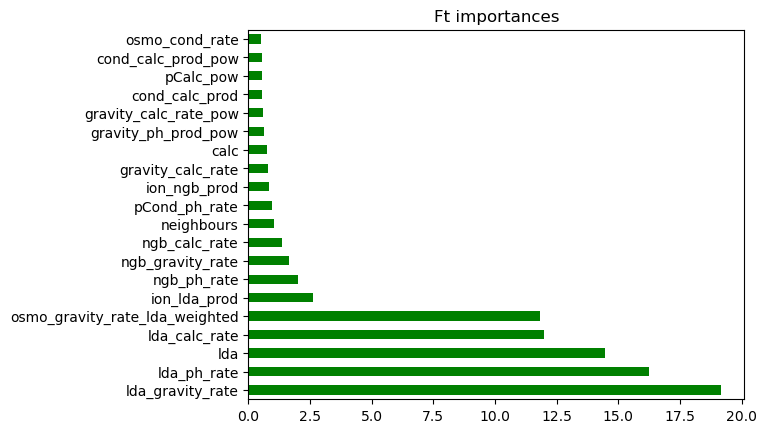

In [11]:
# FIT CatBoost
# cat_features = [col for col in X.columns if 'bins' in col]
cat_features = [col for col in X.columns if X[col].dtype == 'category']
est = checkup(CatBoostClassifier(iterations=250, learning_rate=0.01, depth=3, cat_features=cat_features, random_state=11, verbose=False, allow_writing_files=False), X, folds=7);
feat_importances = pd.Series(est.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh', title='Ft importances', color='green');

### XGBoost

In [1]:
# # FIT XGBoost
# est = checkup(XGBClassifier(n_estimators=250, learning_rate=0.01, max_depth=3, random_state=23), X, folds=7);
# feat_importances = pd.Series(est.feature_importances_, index=X.columns)
# feat_importances.nlargest(20).plot(kind='barh', title='Ft importances', color='purple');

### features selection

100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


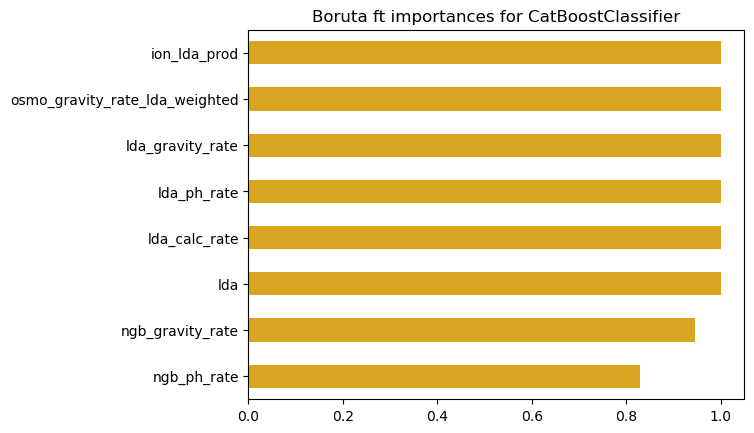

In [12]:
# fast view
imp = boruta(X, y, iterations=10, seed=17, alpha=0.2, estimator=est, plot=True)

100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


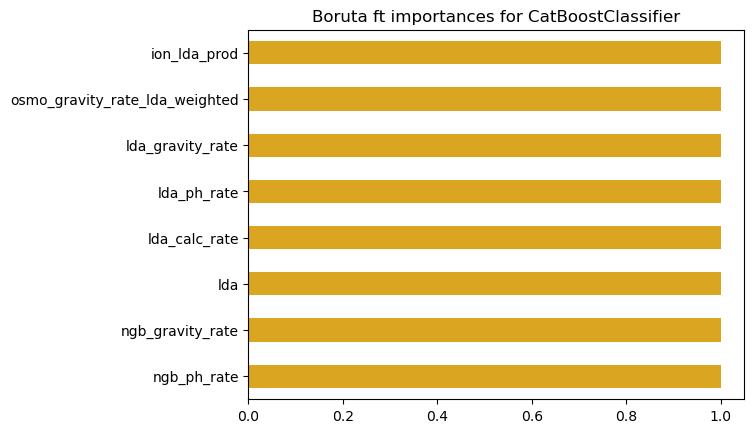

In [15]:
# research
imp = boruta(X, y, iterations=100, seed=17, plot=True, alpha=0.2,
    estimator=CatBoostClassifier(iterations=250, learning_rate=0.01, depth=3, random_state=11, verbose=False, allow_writing_files=False)
)

In [92]:
# top 20 worst features
imp.nsmallest(20)

gravity                        7.888609e-31
ph                             7.888609e-31
osmo                           7.888609e-31
cond                           7.888609e-31
urea                           7.888609e-31
pUr                            7.888609e-31
pOs                            7.888609e-31
pCond                          7.888609e-31
gravity_ph_rate                7.888609e-31
gravity_ph_prod                7.888609e-31
gravity_osmo_prod              7.888609e-31
gravity_calc_rate              7.888609e-31
osmo_cond_rate                 7.888609e-31
osmo_urea_prod                 7.888609e-31
osmo_ph_prod                   7.888609e-31
cond_urea_prod_ph_rate         7.888609e-31
gravity_osmo_prod_urea_rate    7.888609e-31
pOs_gravity_rate               7.888609e-31
pOs_ph_rate                    7.888609e-31
pCond_ph_rate                  7.888609e-31
dtype: float64

In [ ]:
#